Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомендаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [3]:
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (20,20)
import numpy as np
import requests
import csv
import datetime as dt
import re
import pandas as pd
import numpy as np

In [ ]:
#создаем фунцию для работы с vk api, загружаем данные постов не раньше 01.01.19
def vk_parser():
    token = ''
    version = 5.131
    domain = 'skillbox_education'
    finish = 1546214400
    count = 100
    offset = 0
    all_posts = []
    while True:
        new = requests.get('https://api.vk.com/method/wall.get',
                      params={'access_token':token,
                              'v':version,'domain': domain,
                              'count':count,
                             'offset':offset})
        data = new.json()['response']['items']
        temp = data[0]['date']
        offset += 100
        all_posts.extend(data) 
        if temp < finish:
            break       
    return all_posts
full_json = vk_parser()  

In [3]:
#фунция для создания csv-файла, путем парсинга полученных json-данных
def file_writer(data):
    with open('skillbox.csv', 'w',encoding="utf-8") as file:
        new = csv.writer(file)
        new.writerow(('date','posts','likes','reposts','comments','views','votes'))
        vote_list = []
        for post in data:
            try:
                if len(post['text'])==0:
                    new.writerow((post['date'],post['copy_history'][0]['text'],post['likes']['count'],\
                                  post['reposts']['count'], post['comments']['count'],post['views']['count']))
                else:
                    if len(post['attachments'])==2:
                        new.writerow((post['date'],post['text'],post['likes']['count'],post['reposts']['count'],\
                                      post['comments']['count'],post['views']['count'], post['attachments'][1]['poll']['votes']))
                    else:
                        new.writerow((post['date'],post['text'],post['likes']['count'],post['reposts']['count'],\
                                      post['comments']['count'],post['views']['count']))
            except:
                 new.writerow((post['date'],post['text'],post['likes']['count'],post['reposts']['count'],\
                               post['comments']['count'],post['views']['count']))

        
                    
file_writer(full_json)      

In [4]:
#загружаем полученный датафрейм
main = pd.read_csv('skillbox.csv')
# #столбцы с временными периодами: год, месяц, день недели, час
main['date'] = pd.to_datetime(main['date'],unit='s')
main['year_month'] = main['date'].dt.to_period("M").astype(str)
main['year'] = main['date'].dt.year
main['month'] = main['date'].dt.month
main['weekday'] = main['date'].dt.strftime('%w')
#меняем порядковый номер "воскресенья" с 0 на 7
main['weekday'] = main['weekday'].replace('0', '7').astype(int)
main['day'] = main['date'].dt.day_name()
main['hour'] = main['date'].dt.hour
main = main[['date','year_month','year','month','day','weekday','hour','posts','likes','reposts','comments','views','votes']]
main['posts'] = main['posts'].str.lower()
main['posts'] = main['posts'].fillna('открытка')
main = main.loc[main['date']>='2019-01-01 00:00:00']
main = main.sort_values('date', ascending=False)
#формируем список с хэштегами, чтобы создать столбцы с направлениями обучения и рубриками постов
hashtag_list = []
for i,val in enumerate(main['posts']):
    try:
        x1 = re.findall(r'#(\w+)', val)  
        if len(x1)>0:
            hashtag_list.append(x1)
        else:
            hashtag_list.append(None)  
    except:
        pass
main['hashtag'] = np.array(hashtag_list)


In [5]:
#создаем столбец с основными направлениями паблика
main["direction"]=np.nan
dir_number = main.columns.get_loc("direction")
code_words = ['linux','ios','sql','windows','c++','python','js','javascript','php','java','разработчик','код']
for i,val in enumerate(main['posts']):
    if re.findall(r'дизайн', val) or re.findall(r'design', val) or re.findall(r'#friday_type', val):
        main.iloc[i, dir_number] = 'дизайн'
    elif re.findall(r'программ\w+',val) or re.findall(r'code', val):
        main.iloc[i, dir_number] = 'программирование'
    elif re.findall(r'skillbox_маркетинг', val) or re.findall(r'маркетинг', val) or re.findall(r'marketing', val):
        main.iloc[i, dir_number] = 'маркетинг'
    elif re.findall(r'управление', val) or re.findall(r'менеджмент', val) or re.findall(r'management', val):
        main.iloc[i, dir_number] = 'управление'
    elif re.findall(r'мультимедиа', val):
        main.iloc[i, dir_number] = 'мультимедиа'
    elif re.findall(r'вакансии', val) or re.findall(r'карьер\w+', val) or re.findall(r'высшее', val):
        main.iloc[i, dir_number] = 'карьера и образование'
    elif re.findall(r'_игры', val):
        main.iloc[i, dir_number] = 'игры'
    for j in code_words:
        if j in val:
            main.iloc[i, dir_number] = 'программирование'
for i,val in enumerate(main['hashtag']):
    str_val = str(val)
    if re.findall(r'дизайн', str_val) or re.findall(r'design', str_val):
        main.iloc[i, dir_number] = 'дизайн'
    elif re.findall(r'программ\w+',str_val) or re.findall(r'code', str_val) or re.findall(r'программирование',str_val):
        main.iloc[i, dir_number] = 'программирование'
    elif re.findall(r'маркетинг', str_val) or re.findall(r'marketing', str_val):
        main.iloc[i, dir_number] = 'маркетинг'
    elif re.findall(r'управление', str_val) or re.findall(r'менеджмент', str_val) or re.findall(r'management', str_val):
        main.iloc[i, dir_number] = 'управление'
    elif re.findall(r'мультимедиа', str_val):
        main.iloc[i, dir_number] = 'мультимедиа'
    elif re.findall(r'вакансии', str_val) or re.findall(r'карьер\w+', str_val) or re.findall(r'высшее', str_val):
        main.iloc[i, dir_number] = 'карьера и образование'
    elif re.findall(r'игры', str_val):
        main.iloc[i, dir_number] = 'игры'


In [6]:
#создаем столбец с рубриками паблика
main['category']=np.nan
cat_number = main.columns.get_loc("category")
for i,val in enumerate(main['hashtag']):
    str_val = str(val)
    if re.findall(r'дизайн\w+итв', str_val) or re.findall(r'битв\w+', str_val) or re.findall(r'дизайн\w+ба\w+л', str_val)\
    or re.findall(r'дизайн_', str_val) or re.findall(r'design', str_val):
        main.iloc[i, cat_number] = 'дизайн битва'
    if re.findall(r'статья', str_val) or re.findall(r'read', str_val):
        main.iloc[i, cat_number] = 'статья'            
    elif re.findall(r'полезное', str_val):
        main.iloc[i, cat_number] = 'полезное_от_skillbox'
    elif re.findall(r'игра', str_val):
        main.iloc[i, cat_number] = 'игра по управлению'
    elif re.findall(r'расписани', str_val):
        main.iloc[i, cat_number] = 'расписание'
    elif re.findall(r'анонс+', str_val):
        main.iloc[i, cat_number] = 'анонс'
    elif re.findall(r'лекторий', str_val):
        main.iloc[i, cat_number] = 'лекторий'
    elif re.findall(r'конкурс', str_val):
        main.iloc[i, cat_number] = 'конкурс' 
    elif re.findall(r'марафон', str_val):
        main.iloc[i, cat_number] = 'марафон'
    elif re.findall(r'вам\w+лово', str_val):
        main.iloc[i, cat_number] = 'вам_слово_skillbox'
    elif re.findall(r'кейс', str_val):
        main.iloc[i, cat_number] = 'кейс'
    elif re.findall(r'в_закладки', str_val):
        main.iloc[i, cat_number] = 'в_закладки'
    elif re.findall(r'friday_type', str_val):
        main.iloc[i, cat_number] = 'шрифт недели'        
    elif str_val=='репост':
        main.iloc[i, cat_number] = 'репост'
    elif re.findall(r'студенты_skillbox', str_val):
        main.iloc[i, cat_number] = 'студенты_skillbox'
    elif re.findall(r'calendar', str_val):
        main.iloc[i, cat_number] = 'календарь'
    elif re.findall(r'history', str_val):
        main.iloc[i, cat_number] = 'истории'
main['category'] = main['category'].where(~(main['posts']=='открытка'),other='открытка')


In [7]:
main

,date,year_month,year,month,day,weekday,hour,posts,likes,reposts,comments,views,votes,hashtag,direction,category
1,2021-09-01 16:04:37,2021-09,2021,9,Wednesday,3,16,"все мы прекрасно помним, как появлялись пробел...",3,2,1,6205,NaN,None,программирование,NaN
2,2021-09-01 14:21:41,2021-09,2021,9,Wednesday,3,14,"тоже считаете, что в школьной программе слишко...",34,19,0,6732,NaN,None,программирование,NaN
3,2021-08-31 15:55:31,2021-08,2021,8,Tuesday,2,15,"выполнить реальный заказ, пополнить портфолио ...",38,17,0,11212,NaN,None,дизайн,NaN
4,2021-08-31 13:57:59,2021-08,2021,8,Tuesday,2,13,"даже самое безупречное содержание сайта, презе...",25,13,0,9356,NaN,[skillbox_дизайн],дизайн,NaN
5,2021-08-31 12:26:39,2021-08,2021,8,Tuesday,2,12,"не можете определиться, что страшнее: конец ле...",68,43,4,12462,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2019-01-04 09:20:40,2019-01,2019,1,Friday,5,9,"менеджеры, спешим вам рассказать о теории, кот...",52,9,2,14202,NaN,"[read, management]",управление,статья
2090,2019-01-03 14:30:00,2019-01,2019,1,Thursday,4,14,сплоченный коллектив — мечта каждого руководит...,51,13,0,13583,NaN,"[s2jsjk, marketing]",маркетинг,NaN
2091,2019-01-02 16:30:00,2019-01,2019,1,Wednesday,3,16,"дедушка мороз, а можно нам ещё больше студенто...",64,1,2,19442,NaN,None,NaN,NaN
2092,2019-01-02 12:30:00,2019-01,2019,1,Wednesday,3,12,на этом мастер-классе обсудим дизайнерское дно...,64,9,0,14418,NaN,"[sje5lq, design]",дизайн,дизайн битва


In [5]:
total = main.shape[0]
without_hash = len(main[main['hashtag'].isnull()])
percentage = round((without_hash/total)*100,1)
print('Количество записей за требуемый промежуток времени - ', total)
print('Количество записей с хэштегами - ', len(main[main['hashtag'].notnull()]))
print('Количество записей без хэштегов - ', without_hash)
print(f'Доля непомеченных хэштегами постов от общего количества - {percentage}%')

Количество записей за требуемый промежуток времени -  2094
Количество записей с хэштегами -  1871
Количество записей без хэштегов -  223
Доля непомеченных хэштегами постов от общего количества - 10.6%


***Вывод:***

Для анализа активности паблика взят период с 2019 года по настоящее время(время до и в течение пандемии. Доля непомеченных хэштегами постов сообщества составила около 10%, что является хорошим показателем, тем не менее необходимо стремиться к уменьшению количества записей без хэштегов. 

In [6]:
temp_df = main.groupby(['year', 'month']).agg({'likes':['min','max','median','mean']})
temp_df

likes                         
             min   max median        mean
year month                               
2019 1         8  1113   39.5   60.467391
     2         6   521   33.0   51.153846
     3         5   740   39.0   72.581395
     4         7   983   44.0   79.222222
     5         5   506   45.0   69.259740
     6         9   803   41.0   67.835821
     7        10   165   35.0   46.985507
     8         8   186   36.0   48.569620
     9         6   250   46.0   54.370968
     10        7   316   47.0   71.698413
     11       12   207   50.0   58.861538
     12       17   645   69.0  101.166667
2020 1        17   440   68.0   89.403846
     2        12   617   62.0  115.928571
     3        13   534   57.0   93.881356
     4        22   430   63.5   97.960000
     5        32   940   87.0  152.897436
     6        24   330   58.0   83.568966
     7        21   379   69.0   90.650000
     8        19   313   67.0   92.545455
     9        15   450   61.0   96.622642
     10       19   652   75.0  129.090909
     11       28   538   71.5  113.083333
     12       33   460   72.0   90.964912
2021 1        32   411   71.0  110.813953
     2        18   275   55.0   76.090909
     3        14   295   40.0   58.516667
     4        18   269   48.5   68.151515
     5        14   151   47.0   56.789474
     6        15   119   34.0   40.932203
     7        11   366   27.0   47.367647
     8         8   343   33.0   49.030303
     9         3    34   18.5   18.500000

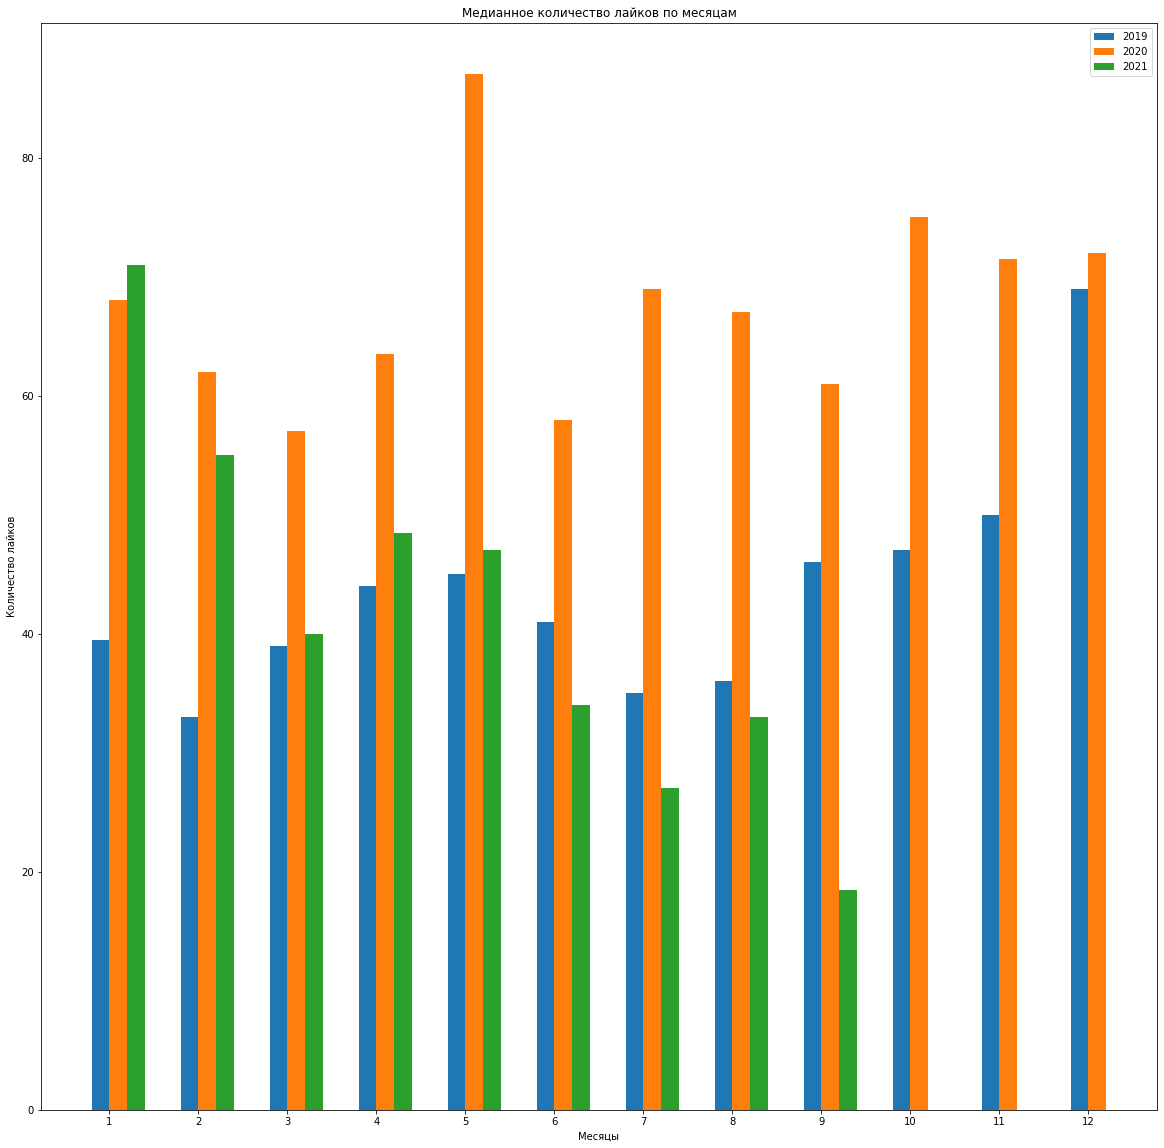

<Figure size 5760x5760 with 0 Axes>

In [8]:
year_lst = main.year.unique()
year_lst = np.sort(year_lst)
x1 = np.arange(1, 13) - 0.1
x2 = np.arange(1, 13) + 0.1
x3 = np.arange(1, 10) + 0.3
fig, ax = plt.subplots()
ax.bar(x1, temp_df.loc[2019,('likes','median')],width = 0.2)
ax.bar(x2, temp_df.loc[2020,('likes','median')],width = 0.2)
ax.bar(x3, temp_df.loc[2021,('likes','median')],width = 0.2)
plt.xticks(np.arange(1,13))
plt.legend([2019,2020,2021])
plt.title("Meдианное количество лайков по месяцам")
ax.set_xlabel('Месяцы')
ax.set_ylabel('Количество лайков')
plt.figure(figsize=(80,80))
plt.show()

***Вывод:***
На представленном графике виден рост активности паблика в 2020 году, с максимумом в мае, что соответствует времени локдауна. Показатели 20го года в-целом превышают ппоказатели 19го. В 21м году можно наблюдать высокую активность пользователей, в первые месяцы года превышающую показатели 20 года, однако уже летом эти показатели ниже показателей 19 года, что при учете постоянно возрастающего числа участников сообщества не является хорошим показателем.

In [9]:
temp_df2 = main.groupby(['weekday','day','hour'], as_index = False)\
.agg({'likes': 'median','comments':'median','posts':'count'}).sort_values(['weekday','hour'])
temp_df2

,weekday,day,hour,likes,comments,posts
0,1,Monday,6,37.5,10.5,2
1,1,Monday,7,35.0,4.0,11
2,1,Monday,8,71.0,7.0,29
3,1,Monday,9,43.0,3.5,40
4,1,Monday,10,44.0,3.5,34
...,...,...,...,...,...,...
87,7,Sunday,13,64.0,14.0,4
88,7,Sunday,14,21.5,6.0,2
89,7,Sunday,15,81.0,9.0,3
90,7,Sunday,16,118.0,6.0,9


In [10]:
temp_pivot = temp_df2.pivot_table(index = ['weekday','day'], columns = 'hour', values = 'likes', fill_value = 0)
temp_pivot

,hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
weekday,day,,,,,,,,,,,,,,,,
1,Monday,0,37.5,35.0,71.0,43.0,44.0,51,50.5,57.0,51.5,54.0,56.0,61.0,28.0,23,0
2,Tuesday,0,25.5,33.0,54.5,54.0,67.0,44,41.0,27.0,21.0,49.5,34.0,41.0,19.5,0,15
3,Wednesday,73,36.0,27.0,75.0,58.5,52.5,28,40.0,44.0,34.0,41.0,60.0,56.0,18.0,38,0
4,Thursday,0,0.0,11.0,68.5,53.0,65.0,33,41.0,37.5,52.0,40.5,45.5,47.0,24.0,0,0
5,Friday,0,0.0,42.0,48.0,54.0,69.0,36,44.0,43.0,50.0,45.5,44.0,39.5,28.0,26,0
6,Saturday,0,103.0,44.5,112.5,74.0,62.5,122,63.0,75.0,39.0,54.0,0.0,87.0,49.5,0,0
7,Sunday,0,77.0,303.0,113.5,83.5,91.5,115,53.5,64.0,21.5,81.0,118.0,0.0,0.0,29,0


In [11]:
temp_pivot2 = temp_df2.pivot_table(index = ['weekday','day'], columns = 'hour', values = 'posts', fill_value = 0)
temp_pivot2

,hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
weekday,day,,,,,,,,,,,,,,,,
1,Monday,0,2,11,29,40,34,33,42,31,44,45,51,19,15,1,0
2,Tuesday,0,2,8,18,31,27,20,33,24,49,50,45,13,6,0,1
3,Wednesday,1,3,6,18,34,30,19,42,21,27,49,64,15,2,1,0
4,Thursday,0,0,23,22,33,26,13,42,22,49,54,46,15,11,0,0
5,Friday,0,0,8,25,41,29,26,31,21,42,34,42,14,12,4,0
6,Saturday,0,1,16,26,35,30,7,30,10,17,9,0,3,2,0,0
7,Sunday,0,1,23,18,36,20,20,30,4,2,3,9,0,0,1,0


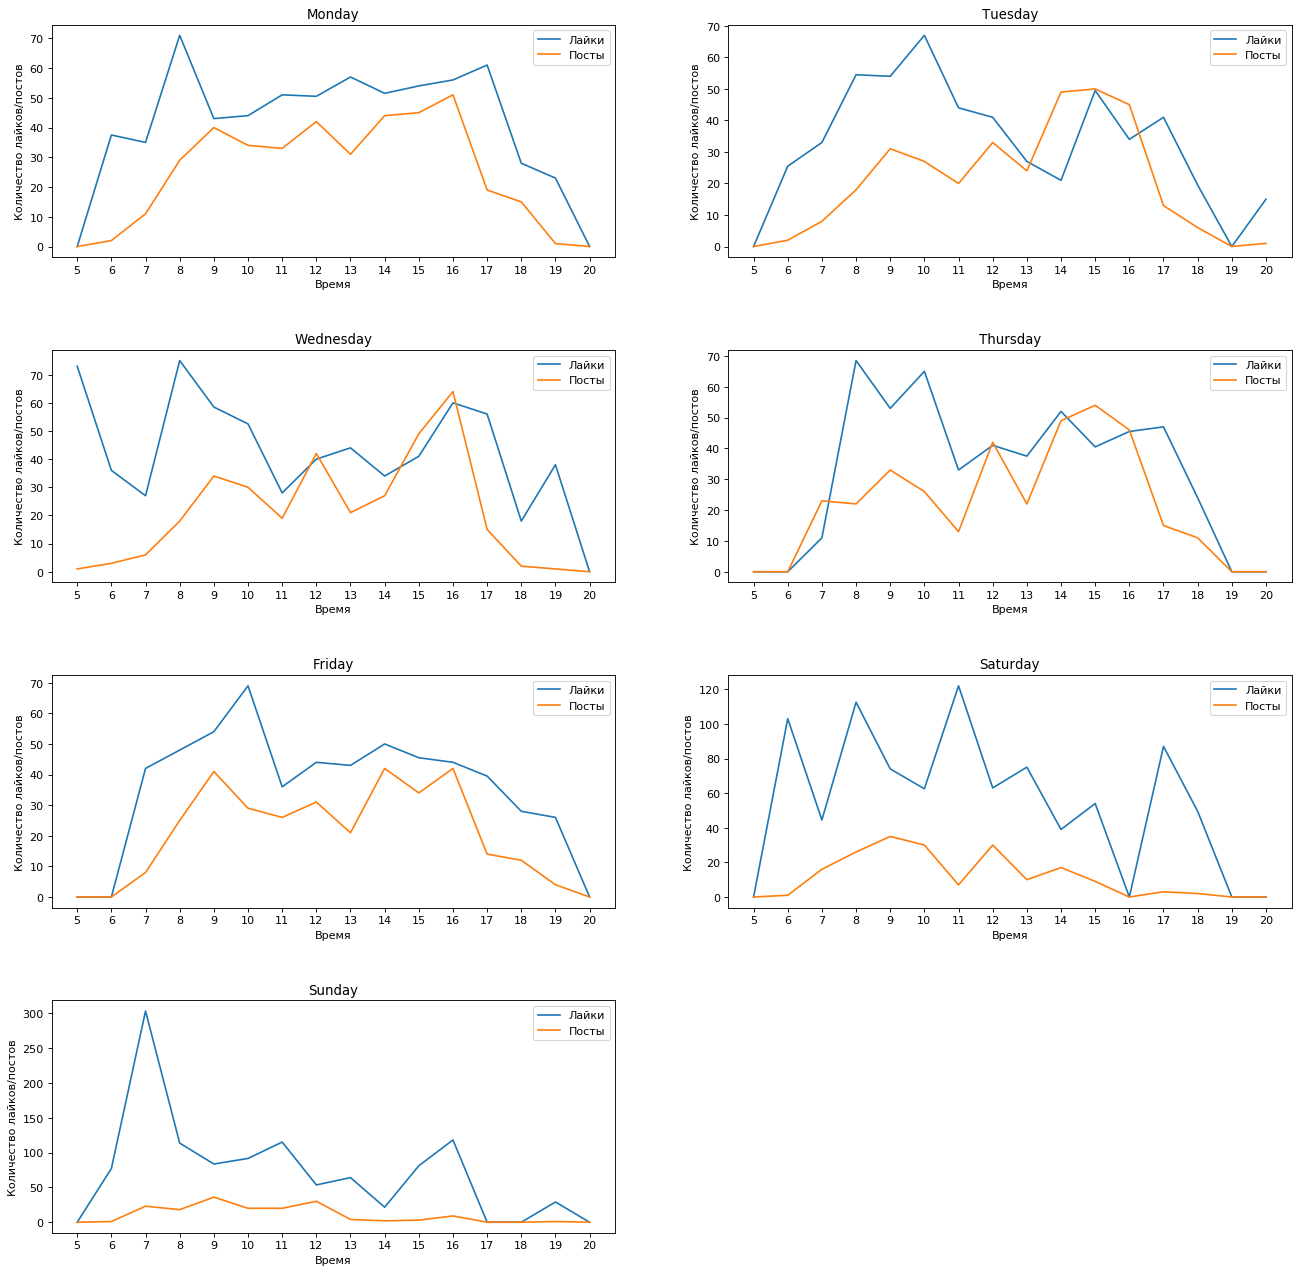

In [12]:
fig = plt.figure(figsize=(20, 20), dpi=80)
for i in range(0,7):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(temp_pivot.columns, temp_pivot.iloc[i])
    ax.plot(temp_pivot.columns, temp_pivot2.iloc[i])
    ax.set_xlabel('Время')
    ax.set_ylabel('Количество лайков/постов')
    plt.xticks(np.arange(5,21))
    plt.title(temp_pivot.iloc[i].name[1])
    plt.legend(['Лайки','Посты'])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

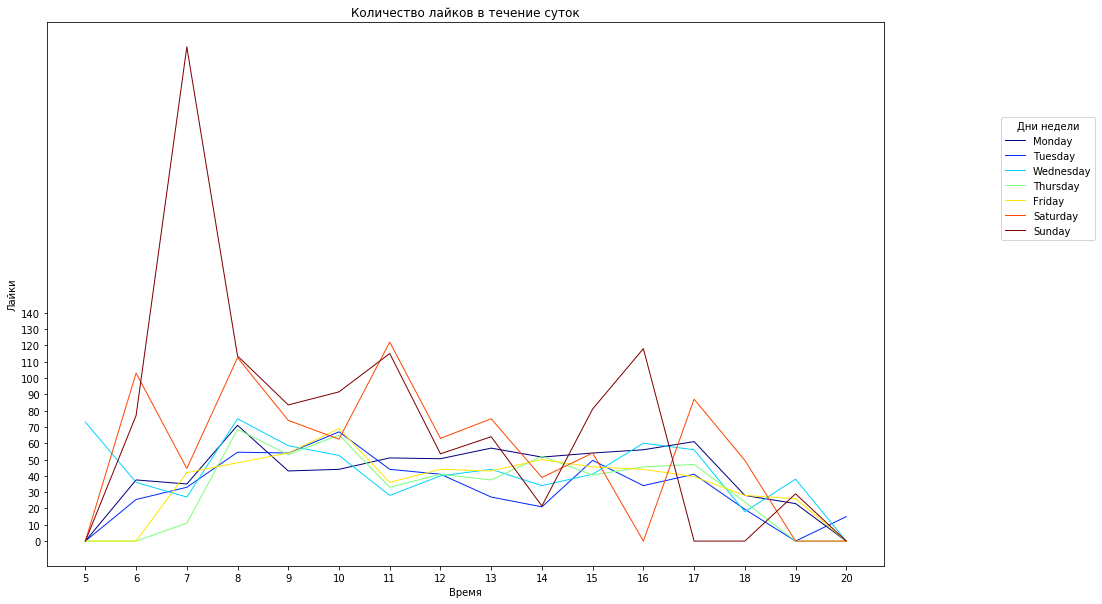

In [13]:
temp_pivot_t = temp_pivot.T.plot(cmap='jet',figsize=(15,10),linewidth = 1)
plt.legend(temp_df2['day'].unique(),      
          title="Дни недели",    
           borderaxespad=4,         
           bbox_to_anchor=(1.3, 0.9), framealpha = 0.8)
plt.title("Количество лайков в течение суток")
temp_pivot_t.set_xlabel('Время')
temp_pivot_t.set_ylabel('Лайки')
plt.xticks(temp_pivot.columns)
plt.yticks(range(0,150,10), labels = range(0,150,10))
plt.show()

***Вывод:***
Посты сообщества сделаны во с 5 до 20 часов. Максимум активности наблюдается в интервале с 7 до 12 часов. Стоит уделить внимание дням недели, в которых количество постов превосходит количество лайков, что может говорить о падении качества контента, либо о его переизбытке, когда пользовтели не успевают оценить/увидеть все сделанные посты. Так же стоит обратить внимание на то, что в определенные дни недели наблюдается достаточно высокая активность пользователей в период с 5 до 7 часов, но количество постов это время минимально.

In [35]:
temp_df3 = main.groupby(['year_month','direction'],as_index=False).agg({'posts':'count','likes':'median'})
temp_pivot3 = temp_df3.pivot_table(index = ['year_month'], columns = 'direction', values = 'likes', fill_value = 0)
temp_pivot3 = temp_pivot3.T
temp_pivot4 = temp_df3.pivot_table(index = ['year_month'], columns = 'direction', values = 'posts', fill_value = 0)
temp_pivot4 = temp_pivot4.T

In [36]:
temp_pivot4

year_month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,...,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
direction,,,,,,,,,,,,,,,,,,,,,
дизайн,25,42,50,41,27,29,33,30,29,24,...,11,16,17,13,17,24,16,16,20,17
игры,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,2,1,0,2,0,0
карьера и образование,0,1,1,0,0,4,3,0,0,0,...,0,1,0,2,3,3,5,4,5,3
маркетинг,16,17,21,24,16,13,9,10,7,15,...,11,9,6,9,14,13,8,6,3,3
мультимедиа,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,2,3,2
программирование,24,26,27,17,10,10,11,9,13,13,...,5,9,7,12,10,9,12,10,13,10
управление,3,6,6,5,6,3,8,14,7,4,...,2,0,3,5,4,1,1,6,6,3


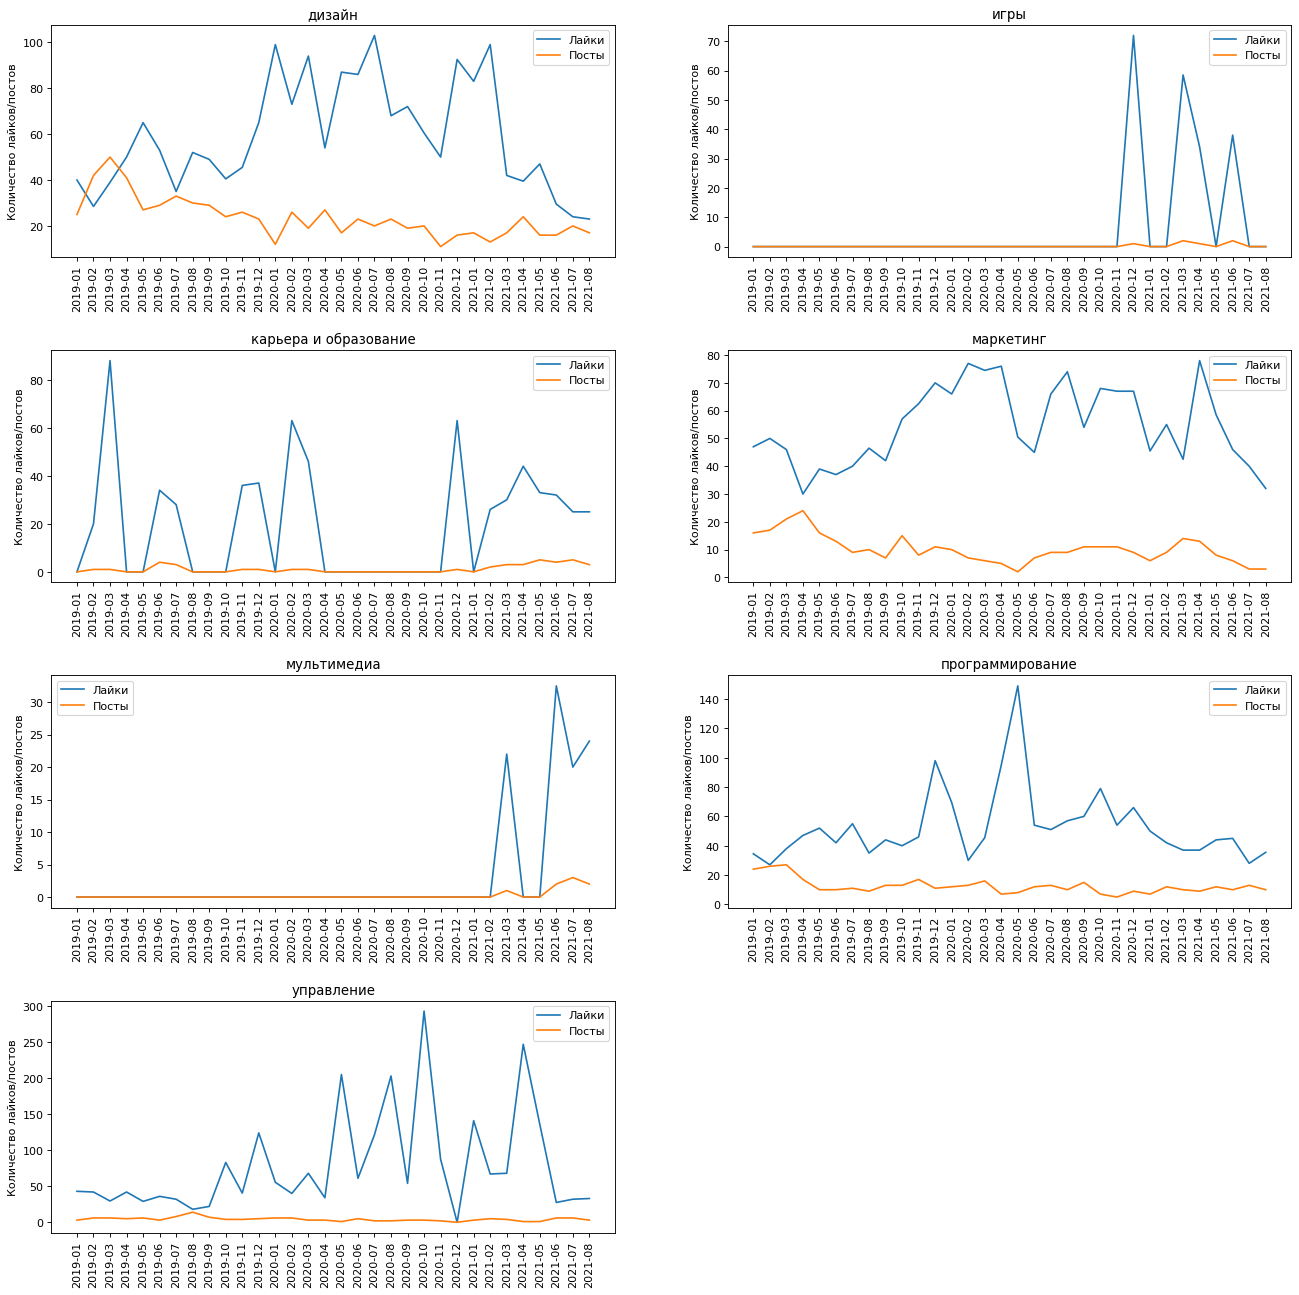

In [43]:
fig = plt.figure(figsize=(20, 20), dpi=80)
for i in range(0,7):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(temp_pivot3.columns, temp_pivot3.iloc[i])
    ax.plot(temp_pivot4.columns, temp_pivot4.iloc[i])
    ax.set_ylabel('Количество лайков/постов')
    plt.xticks(temp_pivot3.columns,rotation=90)
    #plt.yticks(np.arange(0,300,5))
    plt.title(temp_pivot3.index[i])
    plt.legend(['Лайки','Посты'])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [8]:
main.groupby('direction')['direction'].count().sort_values(ascending=False)

direction
дизайн                   758
программирование         403
маркетинг                328
управление               136
карьера и образование     39
мультимедиа                8
игры                       7
Name: direction, dtype: int64

***Вывод:***
Самые популярные направления соответствуют направлениям обучения платформы skillbox. Следует обратить внимание на малое количество постов и в направлении "Управление"; также стоит уделить внимание теме "Карьера и образование", в постах которой наблюадется нерегулярность; также стоит заняться развитием новых направлений "мультимедиа" и "игры".

In [63]:
main.groupby('category').agg({'category':'count','likes':'median'}).sort_values(('likes'),ascending=False)

,category,likes
category,,
в_закладки,172,124.5
студенты_skillbox,14,76.0
кейс,31,74.0
полезное_от_skillbox,30,56.0
конкурс,30,51.0
шрифт недели,21,50.0
статья,540,49.0
расписание,108,44.5
марафон,8,36.5


In [73]:
temp_df5 = main.groupby(['year_month','category'],as_index=False).agg({'posts':'count','likes':'median'})\
                                        .sort_values(('posts'),ascending=False)
temp_pivot5 = temp_df5.pivot_table(index = ['year_month'], columns = 'category', values = 'likes', fill_value = 0)
temp_pivot5 = temp_pivot5.T
temp_pivot5

year_month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,...,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
category,,,,,,,,,,,,,,,,,,,,,
анонс,0.0,0.0,0.0,0.0,0.0,64.5,0.0,19.0,0.0,22.5,...,0.0,0.0,0.0,28.0,31.0,26.0,26.5,24.0,20.0,0.0
в_закладки,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,191.0,116.0,245.0,165.0,87.5,129.0,82.5,93.0,55.0,0.0
вам_слово_skillbox,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,61.0,20.5,...,0.0,0.0,0.0,28.0,28.0,0.0,0.0,0.0,16.0,0.0
дизайн битва,37.5,21.0,25.5,26.0,60.0,45.0,21.5,28.0,17.0,14.0,...,0.0,61.0,107.0,29.0,0.0,71.0,0.0,0.0,0.0,10.0
игра по управлению,0.0,0.0,0.0,0.0,0.0,0.0,22.5,16.0,19.5,19.0,...,0.0,61.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0
истории,33.0,20.0,37.5,35.0,37.0,23.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
календарь,27.5,29.0,28.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
кейс,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,...,0.0,122.0,0.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0
конкурс,0.0,0.0,0.0,0.0,198.0,22.0,0.0,0.0,59.0,77.5,...,0.0,52.5,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0


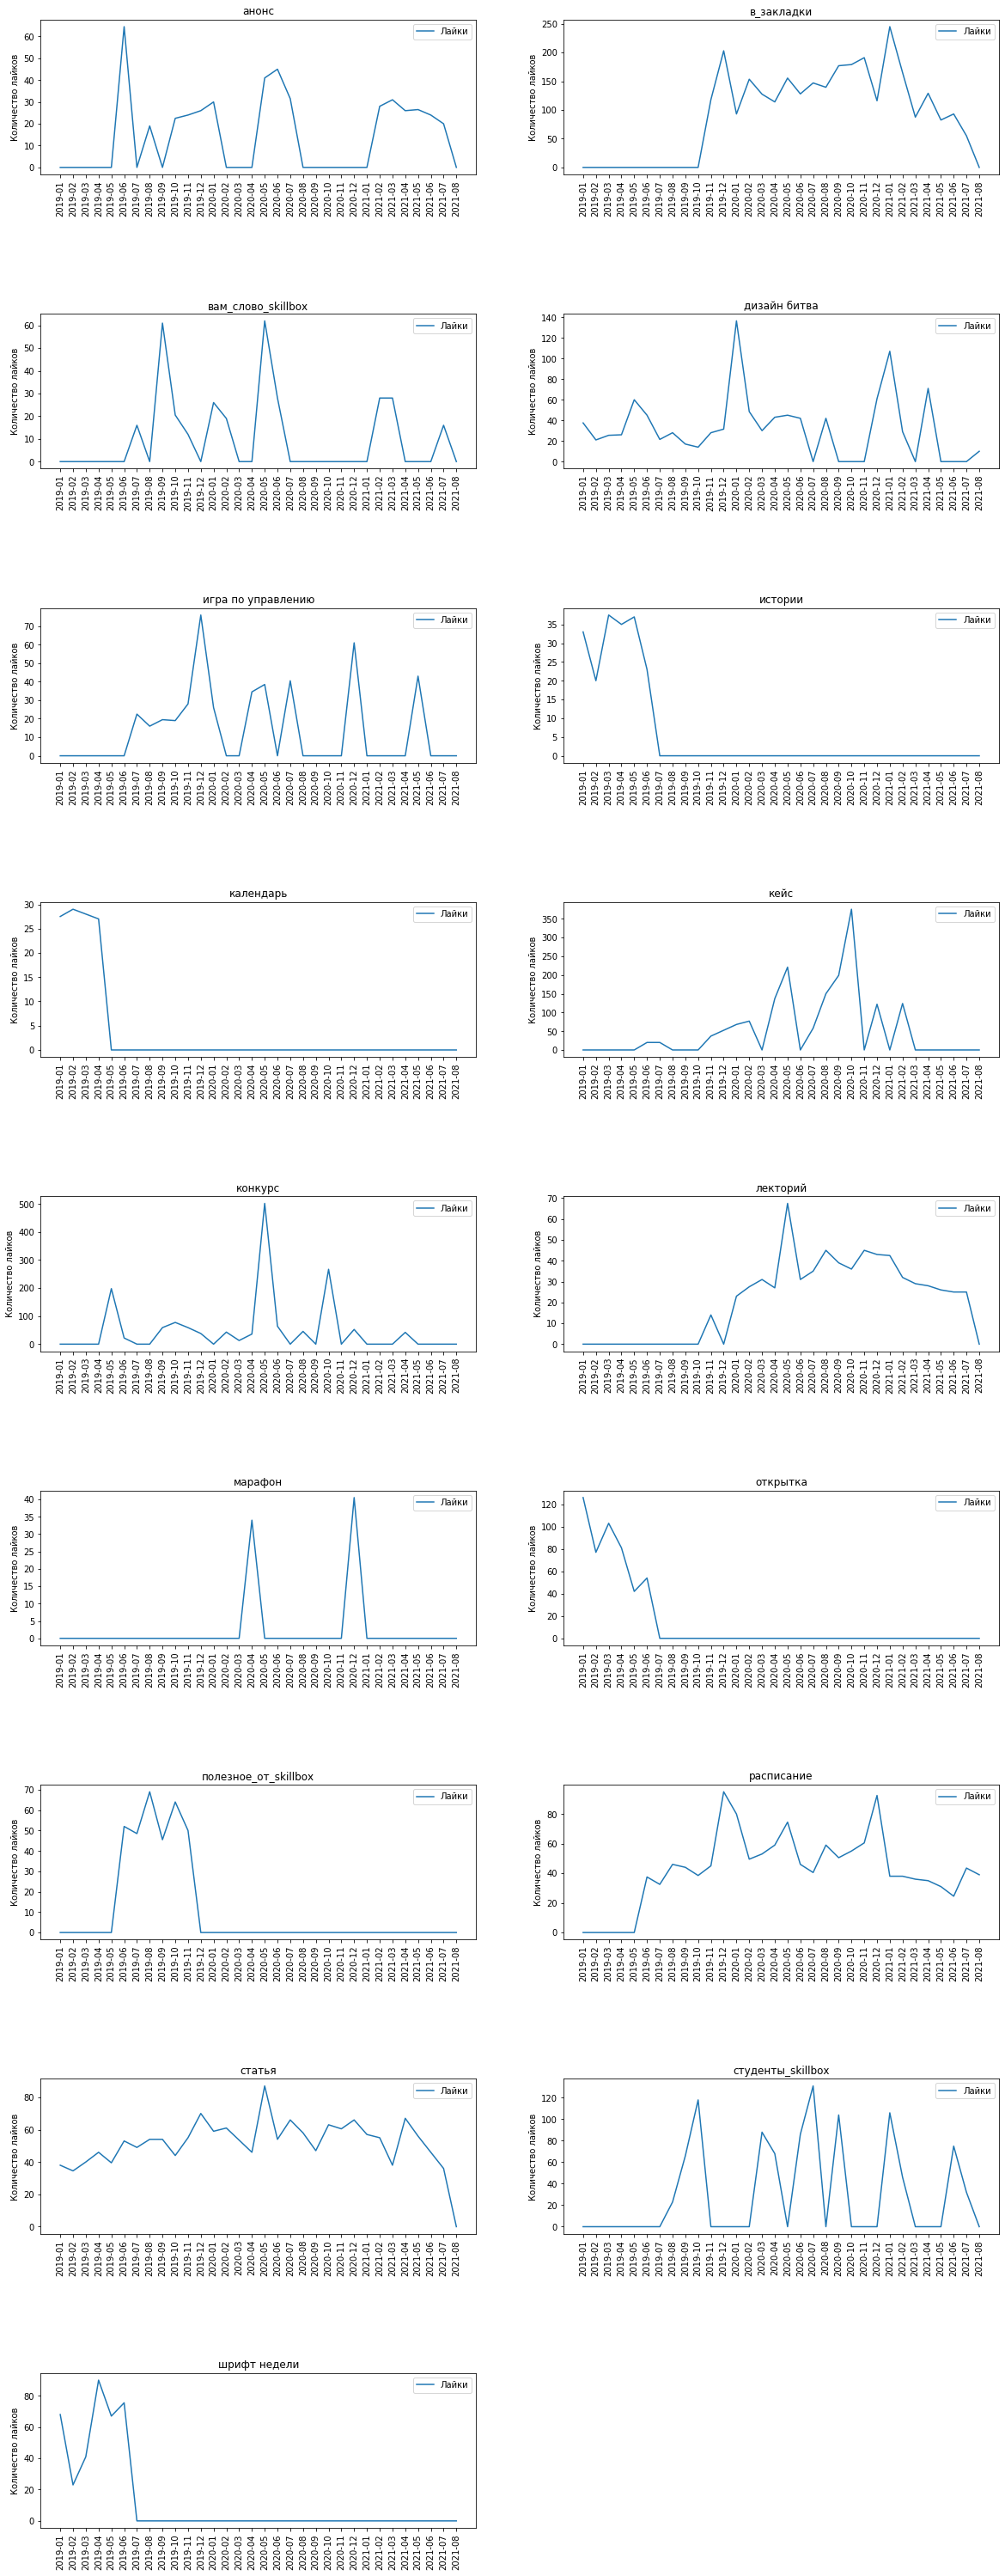

In [104]:
fig = plt.figure(figsize=(20, 60))
for i in range(0,17):
    ax = fig.add_subplot(10, 2, i+1)
    ax.plot(temp_pivot5.columns, temp_pivot5.iloc[i])
    ax.set_ylabel('Количество лайков')
    plt.xticks(temp_pivot5.columns,rotation=90)
    #plt.yticks(np.arange(0,300,5))
    plt.title(temp_pivot5.index[i])
    plt.legend(['Лайки'])
plt.subplots_adjust(wspace=0.2, hspace=0.9)
plt.show()

***Вывод:***
Из полученных графиков можно сделать вывод, что большинство рубрик нерегулярны. Из успешных  и постоянных можно отметить "в_закладки", "статья"  и "лекторий". Стоит развивать рубрики "кейс",  "студенты_skillbox" с высокими показателями отклика и в целом уделить внимание реглярностивыхода постов во всех рубриках.